In [ ]:
# first let's import our packages
import scipy.stats as scs
import os                           # operating system tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data
from scipy.stats import linregress
import matplotlib.pyplot as plt     # plotting
%matplotlib inline

import clusteringFns as clf
import plotFns as psyplt
import helperFns as mf

%load_ext autoreload
%autoreload 2

curPath = os.path.abspath(os.getcwd())

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

np.random.seed(2021)                # set seed for reproducibility

In [ ]:
##### RUN

IDs = ('GS027', 'GS028', 'GS029', 'GS030', 'GS037', 'GS040', 'JC025', 'JC028', 'JC029', 'JC039', 'JC044', 'JC047', 'JC048', 'JC052', 'JC057', 'JC059', 'JC061', 'JC062', 'JC067')

dataBase =  os.path.abspath(os.path.join(curPath,"data/Trajectories/with_bias_learning"))

smoothF = 15
nPoints = 100
smooth2 = 5

sizeQ = True

rawTraceMatResized = np.full([len(IDs),nPoints*3], np.nan)
signedTraceMatResized = np.full([len(IDs),nPoints*2], np.nan)
diffTraceMatResized = rawTraceMatResized.copy()

nPointsVec = np.full([len(IDs),1], np.nan)

avgTraceMatResized = np.full([len(IDs),nPoints], np.nan)

for idi, ID in enumerate(IDs):

    loaded_dict = mf.loadSavedFits(ID, dataBase, ending = '_trainingDataBias')

    acc = np.array(loaded_dict['correct'])
    cat = np.array(loaded_dict['answer'])
    emptyMat = np.empty((1,np.size(acc)))
    emptyMat[:] = np.nan
    emptyMat = emptyMat.squeeze()
    acc_low = emptyMat.copy()
    acc_high = emptyMat.copy()
    acc_low[cat == 1] = acc[cat == 1]
    acc_high[cat == 2] = acc[cat == 2]

    nPointsT, wModeRaws, wModeSigned, wModeDiff, wModeAvg = clf.smoothLearningTraces(acc_low, acc_high, nPoints = nPoints, smoothF = smoothF, smooth2 = smooth2, sameSize = sizeQ)

    if np.size(wModeRaws) > np.size(rawTraceMatResized,1):
        adn = np.full([np.size(rawTraceMatResized,0),np.size(wModeRaws) - np.size(rawTraceMatResized,1)], np.nan)
        
        rawTraceMatResized = np.hstack([rawTraceMatResized, adn])
        signedTraceMatResized = np.hstack([signedTraceMatResized, adn])
        diffTraceMatResized = np.hstack([diffTraceMatResized, adn])
        avgTraceMatResized = np.hstack([avgTraceMatResized, adn])

    elif np.size(wModeRaws) < np.size(rawTraceMatResized,1):
        adn = np.squeeze(np.full([1, np.size(rawTraceMatResized,1) - np.size(wModeRaws)], np.nan))

        wModeRaws = np.hstack([wModeRaws, adn])
        wModeSigned = np.hstack([wModeSigned, adn])
        wModeDiff = np.hstack([wModeDiff, adn])
        wModeAvg = np.hstack([wModeAvg, adn])

    rawTraceMatResized[idi,:] = wModeRaws
    signedTraceMatResized[idi,:] = wModeSigned
    diffTraceMatResized[idi,:] = wModeDiff
    avgTraceMatResized[idi,:] = wModeAvg

signedTraceMatResized = pd.DataFrame(signedTraceMatResized, index = IDs)
avgTraceMatResized = pd.DataFrame(avgTraceMatResized, index = IDs)

ids = np.array(['JC067', 'GS029', 'JC057', 'JC044', 'JC025',  'GS030', 'GS028', 'JC061', 'JC048', 'JC052', 'GS027',
                'JC028', 'JC062', 'JC029', 'GS040', 'JC039','GS037',  'JC059', 'JC047'])

rm = []

x_pred = np.array(range(0,len(ids)))

Xp = avgTraceMatResized.drop(rm)

Xp = np.asarray(Xp)
XpD = pd.DataFrame(Xp,index = IDs)
XpD = XpD.loc[ids]
Xp = np.asarray(XpD)

test = 'slope'
nPointsTemp = int(np.round(nPoints))

df = XpD.iloc[:,0:nPointsTemp].copy()
df[['slope','intercept','r','p','se']] = df.apply(lambda x: linregress(range(1,len(x.dropna())+1), x.dropna().values), axis=1).apply(pd.Series)

print(df[['slope','intercept','r','p','se']])

df['label'] = [0,0,0,0,0,0,0,0,0,2,2,1,1,1,1,1,1,1,1]

dfc = df.copy()

dfc_1 = dfc.loc[dfc['label'] == 1,:]
dfc_1 = dfc_1.sort_values(test, ascending = False)

dfc_0 = dfc.loc[dfc['label'] == 0,:]
dfc_0 = dfc_0.sort_values(test, ascending = False)

print(scs.ttest_ind(dfc_0[test], dfc_1[test]))

dfc = pd.concat([dfc_0, dfc_1],axis = 0)

ordered = np.array(dfc.index)

In [ ]:
# Figure 3A

ids = ordered
Xp = signedTraceMatResized.drop(rm)
Xp = Xp.loc[ids]
Xp = np.array(Xp)

Xp_avg = avgTraceMatResized.drop(rm)
Xp_avg = Xp_avg.loc[ids]
Xp_avg = np.array(Xp_avg)

x_pred = [0,0,0,0,0,0,0,0,0,2,2,1,1,1,1,1,1,1,1]

fig, axs = psyplt.plotClustersVertThreeAx(Xp, Xp_avg, x_pred, nPointsTemp)

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

for ax in axs:

    ax.spines[['right', 'top','bottom']].set_visible(False)
    ax.spines[['left', 'bottom']].set_linewidth(2)
    ax.set_xlim(0,100)
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    plt.setp(axs, ylim=axs[0].get_ylim())

fig.set_size_inches(6,8)

#plt.tight_layout()
plt.show()

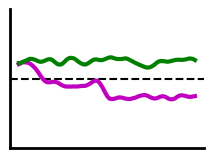

In [ ]:
# Figure 3B

x_pred = pd.DataFrame([0,0,0,0,0,0,0,0,0,2,2,1,1,1,1,1,1,1,1])

fig, ax = psyplt.plotClustersVertAvgOnly(Xp_avg, x_pred[0], nPointsTemp)

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

#for ax in axs:

ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(2)

ax.set_ylim(0.1,0.9)
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left = False,
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

fig.set_size_inches(2.5,1.8)

#plt.tight_layout()
plt.show()

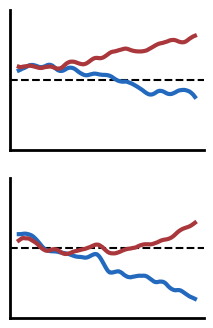

In [ ]:
# Figure 3C-D

ids = ordered
Xp = signedTraceMatResized.drop(rm)
Xp = Xp.loc[ids]
Xp = np.array(Xp)

x_pred = pd.DataFrame([0,0,0,0,0,0,0,0,0,2,2,1,1,1,1,1,1,1,1])

fig, axs = psyplt.plotClustersVert(Xp, x_pred[0], nPoints)

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

for ax in axs:

    ax.spines[['right', 'top']].set_visible(False)
    ax.spines[['left', 'bottom']].set_linewidth(2)
    ax.set_ylim(-0.05,1.05)
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off

fig.set_size_inches(2.5,4)

#plt.tight_layout()
plt.show()
